# What's New - Internal 

## Summary

This new edition of `made-with-gs-quant` is tailored exclusively for our internal users and showcases some of the latest features of the internal gs-quant toolkit. 

In this notebook we find solutions for some the most popular questions we get such as:
+ How do I generate an FX dual binary pricing grid in gs_quant? 
+ How do I load the trade that my client did with us? 
+ How do I price this rates structure live?


The content of this notebook is split into:
1. [Let's get started with gs-quant](#1---Let's-get-started-with-gs-quant)
2. [TDAPI package](#2---TDAPI-package)
3. [Load trade from SecDb](#3---Load-trade-from-SecDb)
4. [Live Pricing](#4---Live-Pricing)

### 1 - Let's get started with gs-quant
Upon installing the `gs-quant` and `gs-quant[internal]` packages ([see here](https://gitlab.gs.com/marquee/analytics/gs_quant_internal#internal-users) for instructions), start your session using your kerberos entitlements directly (no need to register an app).  
                    

In [1]:
from gs_quant.session import GsSession
GsSession.use() 

### 2 - TDAPI package

On top of the [externalised instruments](https://developer.gs.com/docs/gsquant/guides/Pricing-and-Risk/instruments/) supported in gs-quant, TDAPI enables you to directly leverage a wider range of instruments from SecDb, considerably widening the available universe for pricing and risk analytics.

To see which instruments are supported, simply import the package and type `tdapi.[tab]`. 

In [2]:
import gs_quant_internal.tdapi as tdapi

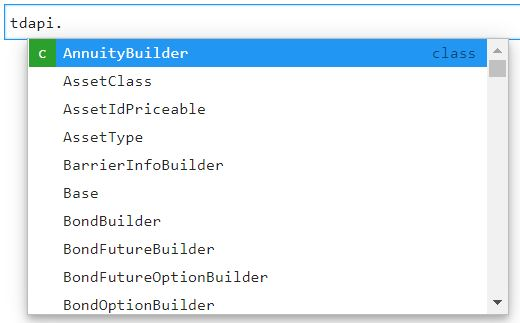

In [6]:
from IPython.display import Image
Image(filename='images/tdapi_package.png')

In this notebook we showcase the use of the TDAPI package using the example of Dual FX Binary Options. 
Let's consider 2 months options with payoff of $10M if strike 1 < EURUSD and GBPUSD < strike 2. These options are composed of 2 nested legs built as below.

In [3]:
from gs_quant.markets.portfolio import Portfolio

def FXDualBinaryOption(pair_1, pair_2, strikes_1, strikes_2, expiry, size):
    portfolio = Portfolio()
    for strike_1 in strikes_1:
        for strike_2 in strikes_2:
            over, under = pair_1.split('/')
            leg_1 = tdapi.FXMultiCrossBinaryChildBuilder(over=over, under=under, strike=strike_1)
            over, under = pair_2.split('/')
            leg_2 = tdapi.FXMultiCrossBinaryChildBuilder(over=over, under=under, strike=strike_2, striketype='Binary Put')
            dual = tdapi.FXMultiCrossBinaryBuilder(expiry=expiry, size=size, legs=(leg_1, leg_2), premium=0)
            portfolio.append(dual)
    return portfolio


For assistance while building the instrument, `shif+tab` on the instrument name displays the list of parameters.

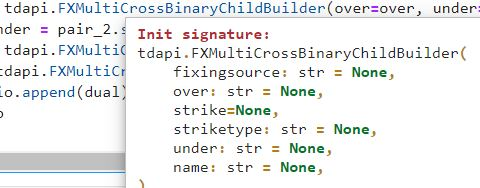

In [5]:
from IPython.display import Image
Image(filename='images/instrument_help.png')

For each leg we consider a range of 9 possible strikes varying around the current spot rate of the associated currency pair. We build a portfolio of 81 options (9 USD/EUR strikes x 9 USD/GBP strikes) and compute the price for each option as a percentage of the payoff. Please note that the code uses internal SecDB notation for FX crosses (e.g. USD/EUR).

In [4]:
eur_strikes = ["s{:+}%".format(x) for x in range(-4, 5)]
gbp_strikes = ["s{:+}%".format(x) for x in range(-4, 5)]

dual_options = FXDualBinaryOption('USD/EUR', 'USD/GBP', eur_strikes, gbp_strikes, '2m', 10e6)

In [5]:
from gs_quant.markets import PricingContext
import pandas as pd

with PricingContext():
    dual_prices = dual_options.dollar_price()

prices = pd.DataFrame(index=eur_strikes, columns=gbp_strikes)
for dual in dual_options:
    prices.loc[dual.legs[0].strike][dual.legs[1].strike] = dual_prices[dual] / 10e6

We can now visualise the price repartition of the options on the strike grid.

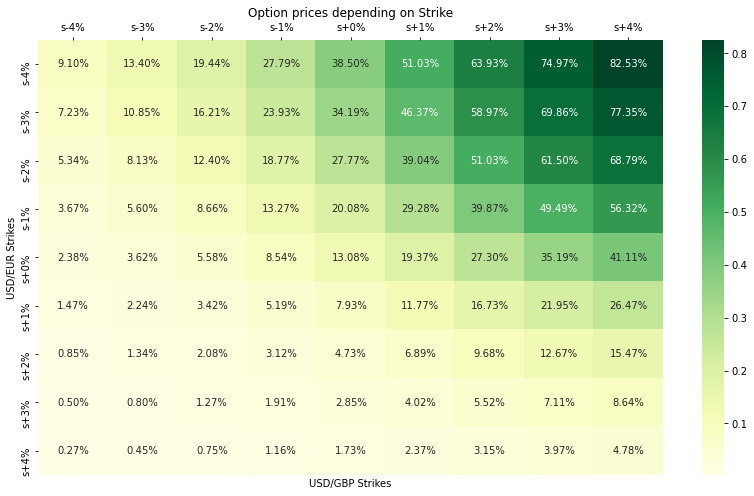

In [6]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.subplots(figsize=(14, 8))
ax = sns.heatmap(prices.apply(pd.to_numeric), annot=True, fmt='.2%', cmap='YlGn')
ax.set(ylabel='USD/EUR Strikes', xlabel='USD/GBP Strikes', title='Option prices depending on Strike')
ax.xaxis.tick_top()

By looking at prices as a % of premium, we can assimilate this grid of binary prices to the discounted value of the risk neutral probability of both crosses being in the money in two months time. This begs the question of how correlated they are and what premium we are saving from the correlation effect of USD/EUR and USD/GBP for the various different events.

Let's investigate by building a similar price grid for the individual binary options represented by the two legs. 

In [8]:
def FXBinaryOptionPrice(pair, strike, expiry, size, optiontype='Call'):
    over, under = pair.split('/')
    with PricingContext():
        option = tdapi.FXBinaryBuilder(over=over, under=under, strike=strike, expiry=expiry, size=size,
                                       premium=0, optiontype=optiontype)
        price = option.dollar_price()
    return price.result()

In [9]:
indep_prices = pd.DataFrame(index=eur_strikes, columns=gbp_strikes)
for dual in dual_options:
    eurusd_price = FXBinaryOptionPrice('USD/EUR', dual.legs[0].strike, expiry='2m', size=10e6)
    gbpusd_price = FXBinaryOptionPrice('USD/GBP', dual.legs[1].strike, expiry='2m', size=10e6,
                                        optiontype='Put')
    indep_prices.loc[dual.legs[0].strike][dual.legs[1].strike] = eurusd_price/10e6 * gbpusd_price/10e6

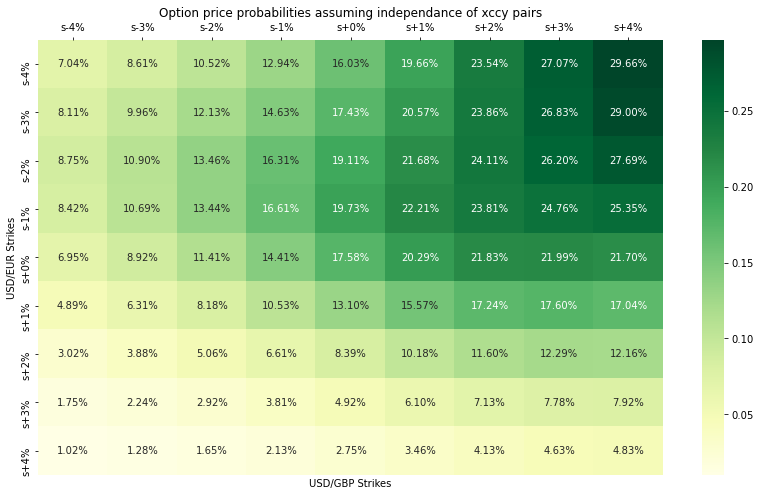

In [10]:
plt.subplots(figsize=(14, 8))
ax = sns.heatmap(indep_prices.apply(pd.to_numeric)-prices.apply(pd.to_numeric), annot=True, fmt='.2%', cmap='YlGn')
ax.set(ylabel='USD/EUR Strikes', xlabel='USD/GBP Strikes', title='Option price probabilities assuming independance of xccy pairs')
ax.xaxis.tick_top()

By comparing the prices of the individual binary options in the above table to that of the dual binary option, you can see an approximation for the premium saved (or cost) from the correlation factor of the events.

## 3 - Load trade from SecDb

Going one step further into leveraging the resources of SecDb, as an internal users you are now able to load real SecDb trades or portfolio of trades referenced by their SecDb ETI or Book ID.
With this feature you can now run concrete risk analysis your own book. 

With `from_book()` you can easily create a portfolio from your existing SecDb book:

In [30]:
portfolio = Portfolio.from_book('my Book ID') # replace with your secDb book ID e.g. '76037320'

Your gs-quant portfolio now contains instruments based on your SecDb book leaves:

In [32]:
portfolio.as_dict()['instruments'][:5]

(SDBBZCJ333333WQR3D (CashPaymentBuilder),
 SDBBZCJ333333WQR3D (CashPaymentBuilder),
 LTAABBCS3333PGQGCZ7A (IRSwaptionBuilder),
 LTAABBCS3333PGQGCZ7A (CashPaymentBuilder),
 LTAABBCS3333NRX9CCJA (CashPaymentBuilder),
 LTAABBCS3333NRX9CCJA (IRSwaptionBuilder))

You can use all the gs-quant functionalities to price and calculate any of the available risk measures on your own portfolio:

In [33]:
from gs_quant.risk import DollarPrice, IRDeltaParallel
results = portfolio.calc((DollarPrice, IRDeltaParallel))

To view risk results, you may directly reference the SecDb leaf:

In [167]:
results[portfolio['my leaf name']] # replace with your SecDb leaf e.g. 'LTAABBCS3333PGQGCZ7A'

({DollarPrice (RiskMeasure): -191826.0084344892,
  IRDeltaParallel (RiskMeasure): -13401.772371713341},
 {DollarPrice (RiskMeasure): 701555.9420614609,
  IRDeltaParallel (RiskMeasure): -14.823504145097733})

Or view book level results:

In [36]:
results[DollarPrice].aggregate()

122075528.76810677

For trades involving supported instruments, `from.eti()` creates a gs-quant portfolio directly from the existing SecDb trade referenced by the ETI number:

In [ ]:
portfolio = Portfolio.from_eti('my ETI number') # Replace with your ETI trade number

With `from_book` and `from_eti`, you can now fully leverage the gs-quant risk package on your own SecDb books! **Please note that all portfolio types are not yet handled.** Should you experience any issue, reach-out to the `gs-quant` distro.
For more examples of what you can do with Portfolios, refer to the [examples folder](https://nbviewer.jupyter.org/github/goldmansachs/gs-quant/tree/master/gs_quant/examples/) and [previous made_with_gs_quant notebooks](https://nbviewer.jupyter.org/github/goldmansachs/gs-quant/tree/master/gs_quant/made_with_gs_quant/) of `made_with_gs_quant`.

### 4 - Live Pricing

Finally, another powerful new feature brought to our internal users is the ability to get live prices.

Re-using the dual option portfolio built in the first section, let's compare our portfolio price under yesterday's market data at close and live pricing environments.
Here we use a PricingContext with batch to group the requests together and avoid timeouts.

In [21]:
from gs_quant.markets import LiveMarket

live_pricing = PricingContext(market=LiveMarket('LDN'), market_data_location='LDN')
close_pricing = PricingContext(is_batch=True, is_async=True)

with live_pricing:
    prices_live = dual_options.dollar_price()
with close_pricing:
    prices_close = dual_options.dollar_price()
    
print('{:,.0f}'.format(prices_live.aggregate()))
print('{:,.0f}'.format(prices_close.aggregate()))

160,206,436
158,675,150


`LiveMarket` accesses the latest market data available for the specified market location. This means you can now use gs-quant to compute real-time prices and intra-day risk on your portfolio.

This closes this first internal edition of `made_with_gs_quant` please continue sharing your feedback on to make `gs-quant` even more useful to you, and look out for the next editions of `What's New` in `made_with_gs_quant`. 

Happy hacking!